# Reduced coverage experiments
Where the set of entries contrained in one thesaurus is constrained to match another, smaller thesaurus. This lets us look at performance differences due to 

 - higher coverage of space of all words/phrases (due to different filtering or algorithm specifics), versus 
 - better vector quality
 
There are currently (19-5-15) two sets of such experiments, both for NPs only:
 - w2v vectors reduced to the coverage of count-windows vectors
 - count-windows reduced to coverage of Baroni vector

In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from copy import deepcopy
from notebooks.common_imports import *
from gui.output_utils import *
from gui.user_code import pretty_names
from pprint import pprint

/Users/miroslavbatchkarov/NetBeansProjects/ExpLosion


In [2]:
def plot_matching(exp_with_constraints, labels=None, rotation=60):
    matching = []
    for e in exp_with_constraints:
        settings = settings_of(e.id)
        settings['expansions__entries_of_id'] = None
        matching.append(Experiment.objects.get(**settings))
    
    ids1 = list(exp_with_constraints.values_list('id', flat=True))
    ids2 = [x.id for x in matching]
    if not labels:
        labels = ['%s-%s'%(a.id, b.id) for a,b in zip(exp_with_constraints, matching)]
    diff_plot_bar([ids1, ids2], ['Limited', 'Unlimited'],
                  labels, rotation=rotation, hue_order=['Unlimited', 'Limited'])

[146, 148, 150, 152]
Running significance for experiments [146, 132]
Running significance for experiments [148, 133]
Running significance for experiments [150, 134]
Running significance for experiments [152, 135]


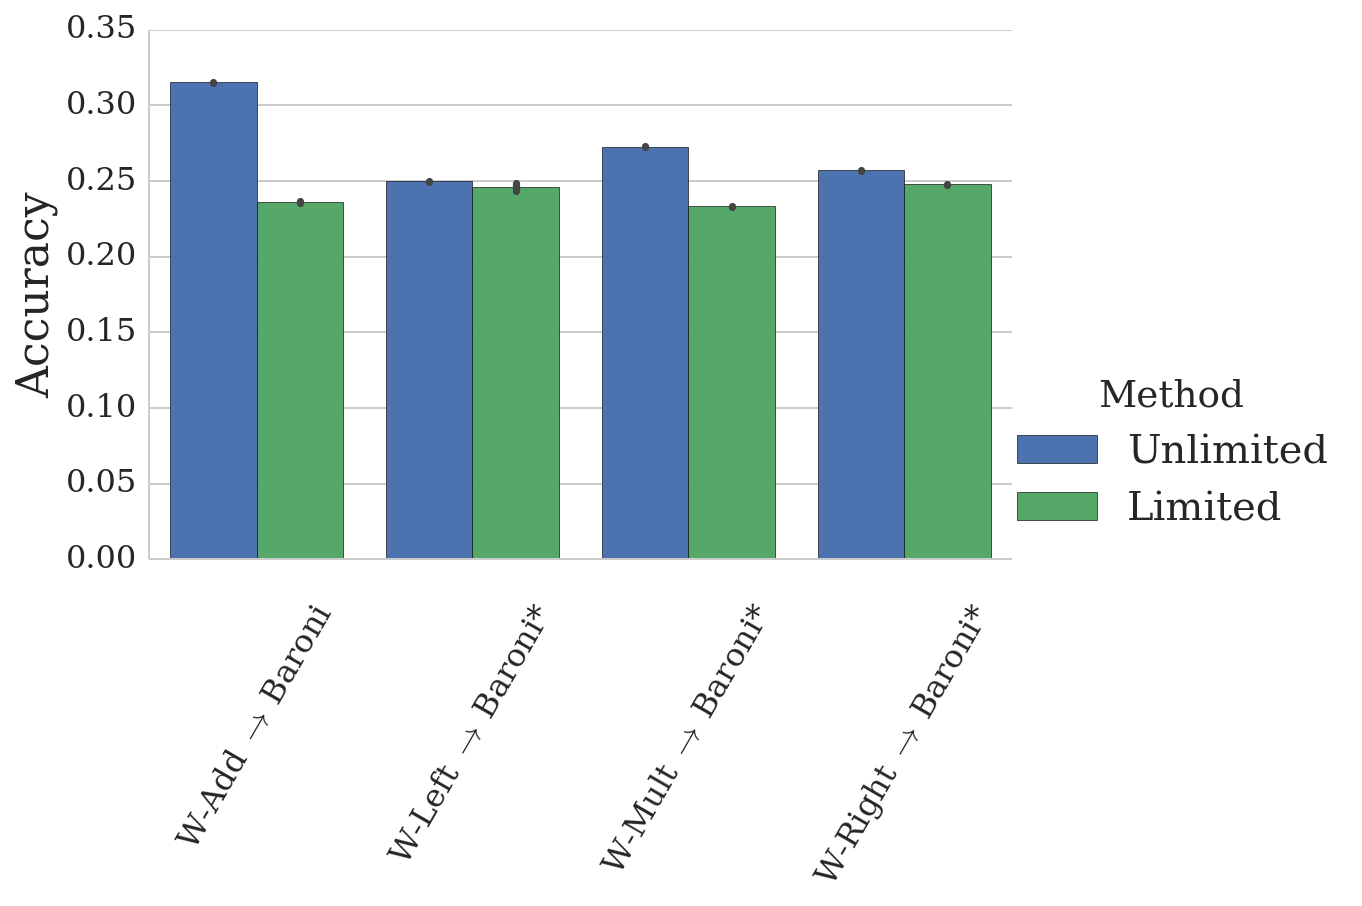

In [3]:
%load_ext autoreload
%autoreload
experiments = Experiment.objects.filter(expansions__entries_of__isnull=False, expansions__entries_of__composer='Baroni')
names = pretty_names([x.id for x in experiments])
names = [r'%s $\rightarrow$ Baroni' % n for n in names]
print(experiments.values_list('id', flat=True))
plot_matching(experiments, labels=names)

Running significance for experiments [145, 97]
Running significance for experiments [147, 107]
Running significance for experiments [149, 117]
Running significance for experiments [151, 127]


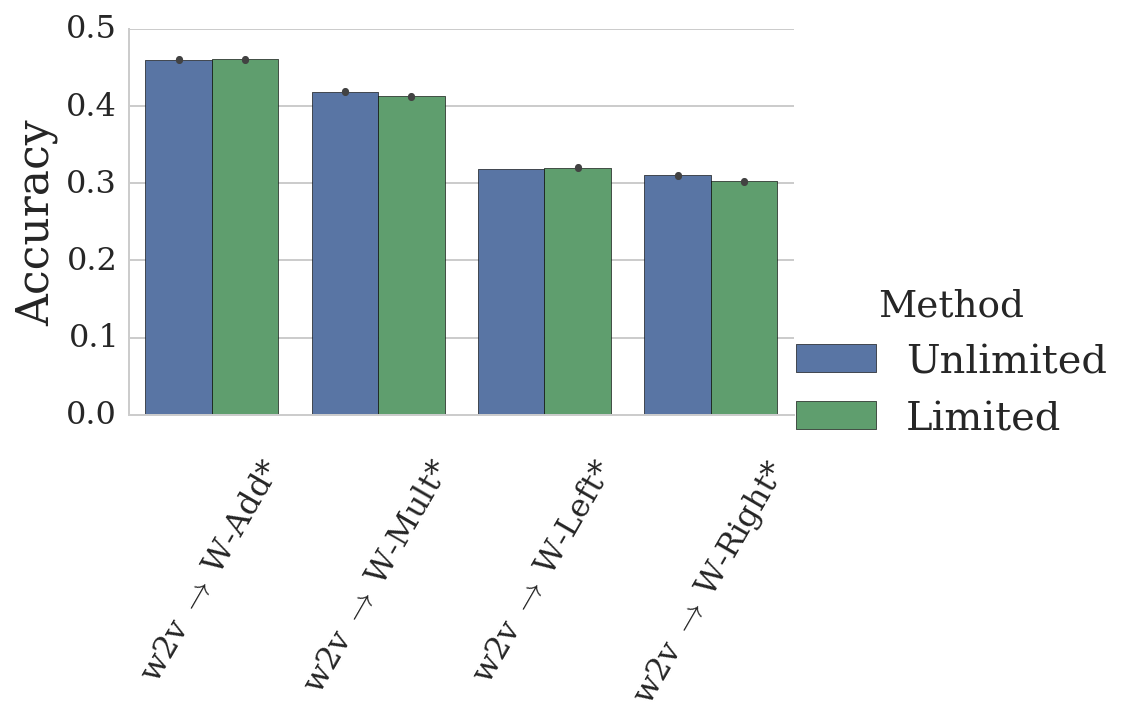

In [4]:
exp_ids = Experiment.objects.filter(expansions__entries_of__isnull=False).exclude(expansions__entries_of__composer='Baroni')
names = pretty_names([x.id for x in exp_ids], name_format=['expansions__vectors__composer'])
names = ['w2v $\\rightarrow$ W-%s' % n for n in names]
plot_matching(exp_ids, labels=names)